# Model Architecture

CycleGAN is an interesting architecture. The idea behind GANs or Generative Adversarial Networks is that one configures a Generator and a Descriminator to train together with competing goals. The generator learns to mimic samples from some domain while the discriminator learns binary classification to identify real versus the generated samples.

The CycleGAN architectue builds on the GAN architecture by pairing a GAN network from domain A to domain B with another GAN network from domain B to domain A. In image processing  this allows the generators to learn tranformations from one image domain to another without requiring paired samples from both domains. This can be a big advantage because a large collection of pair sample images may be expensive or impossible to obtain.

The way that the CycleGAN architecture avoids the need for paired images is to train the networks on making complete round trips:

* Domain A -> Domain B -> Domain A
* Domain B -> Domain A -> Domain A

The loss functions for the generators include both:

* a loss for correct decisons by the discriminator to learn better imitations of the target domain
* a loss based on information lost in the round trip back to the original domain

The loss functions for the discriminators are a usual binary classification loss based on the number of real and generated samples identified correctly.

I found a very concise overview diagram of the CycleGAN architecture in this github project (3) Public Github Project: CycleGAN An implementation of CycleGan for learning an image-to-image translation without input-output pairs using Keras. https://github.com/EtokonE/CycleGAN-keras#cyclegan

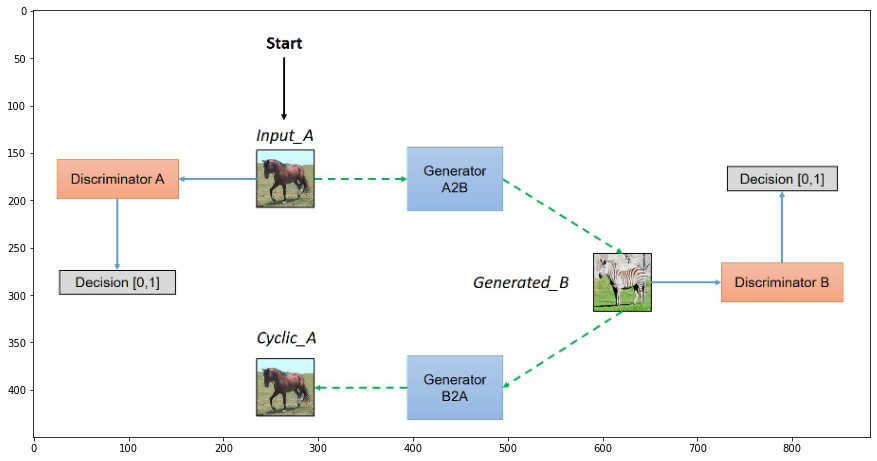

In [24]:
import matplotlib.image as img
import matplotlib.pyplot as plt
image = img.imread("CycleGAN Overview Capture.PNG")
plt.figure(figsize=(15,15))
plt.imshow(image)

I started my project with a copy of the Monet CycleGAN Tutorial notebook on Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook . This notebook already has code defining the CycleGAN architecture, and code for reading the images in TFRecords format, as well as configuration for using TPU hardware acceleration in a Kaggle notebook.

I then worked on figuring out how to tune and train the model to try to get a competitive result.

## Generator Model Overview

Each of the 2 generators consists of 8 downsampling layers followed by 8 upsampling layers with "skip" connections from the outputs of the first seven downsampling layers to the corresponding upsampling layer at each depth. Each downsampling layer uses a Conv2D transformation with a 4x4 kernel and a stride of 2. Each input image starts out as 256 by 256 pixels by 3 channels. Each downsampling layer reduces horizontal and vertical dimension by a factor of 2. There are 512 filters at the innermost level where the image has been reduced to 1 width by 1 height. Therefore each image is compressed down to 512 latent features at the innermost level. This is followed by 8 upsampling layers each of which uses a Conv2DTranspose to double the horizontal and vertical dimensions until at the last layer we have an image restored to 256 by 256 pixels by 3 channels.

The skip connections serve to avoid the vanishing gradient issue, since this is a fairly deep network architecture. The skip connections also allow additional information about the original image to be selectively passed through to the output at each level of the upsampling.

The generator model diagram using keras.utils.vis_utils.plot_model is shown below:


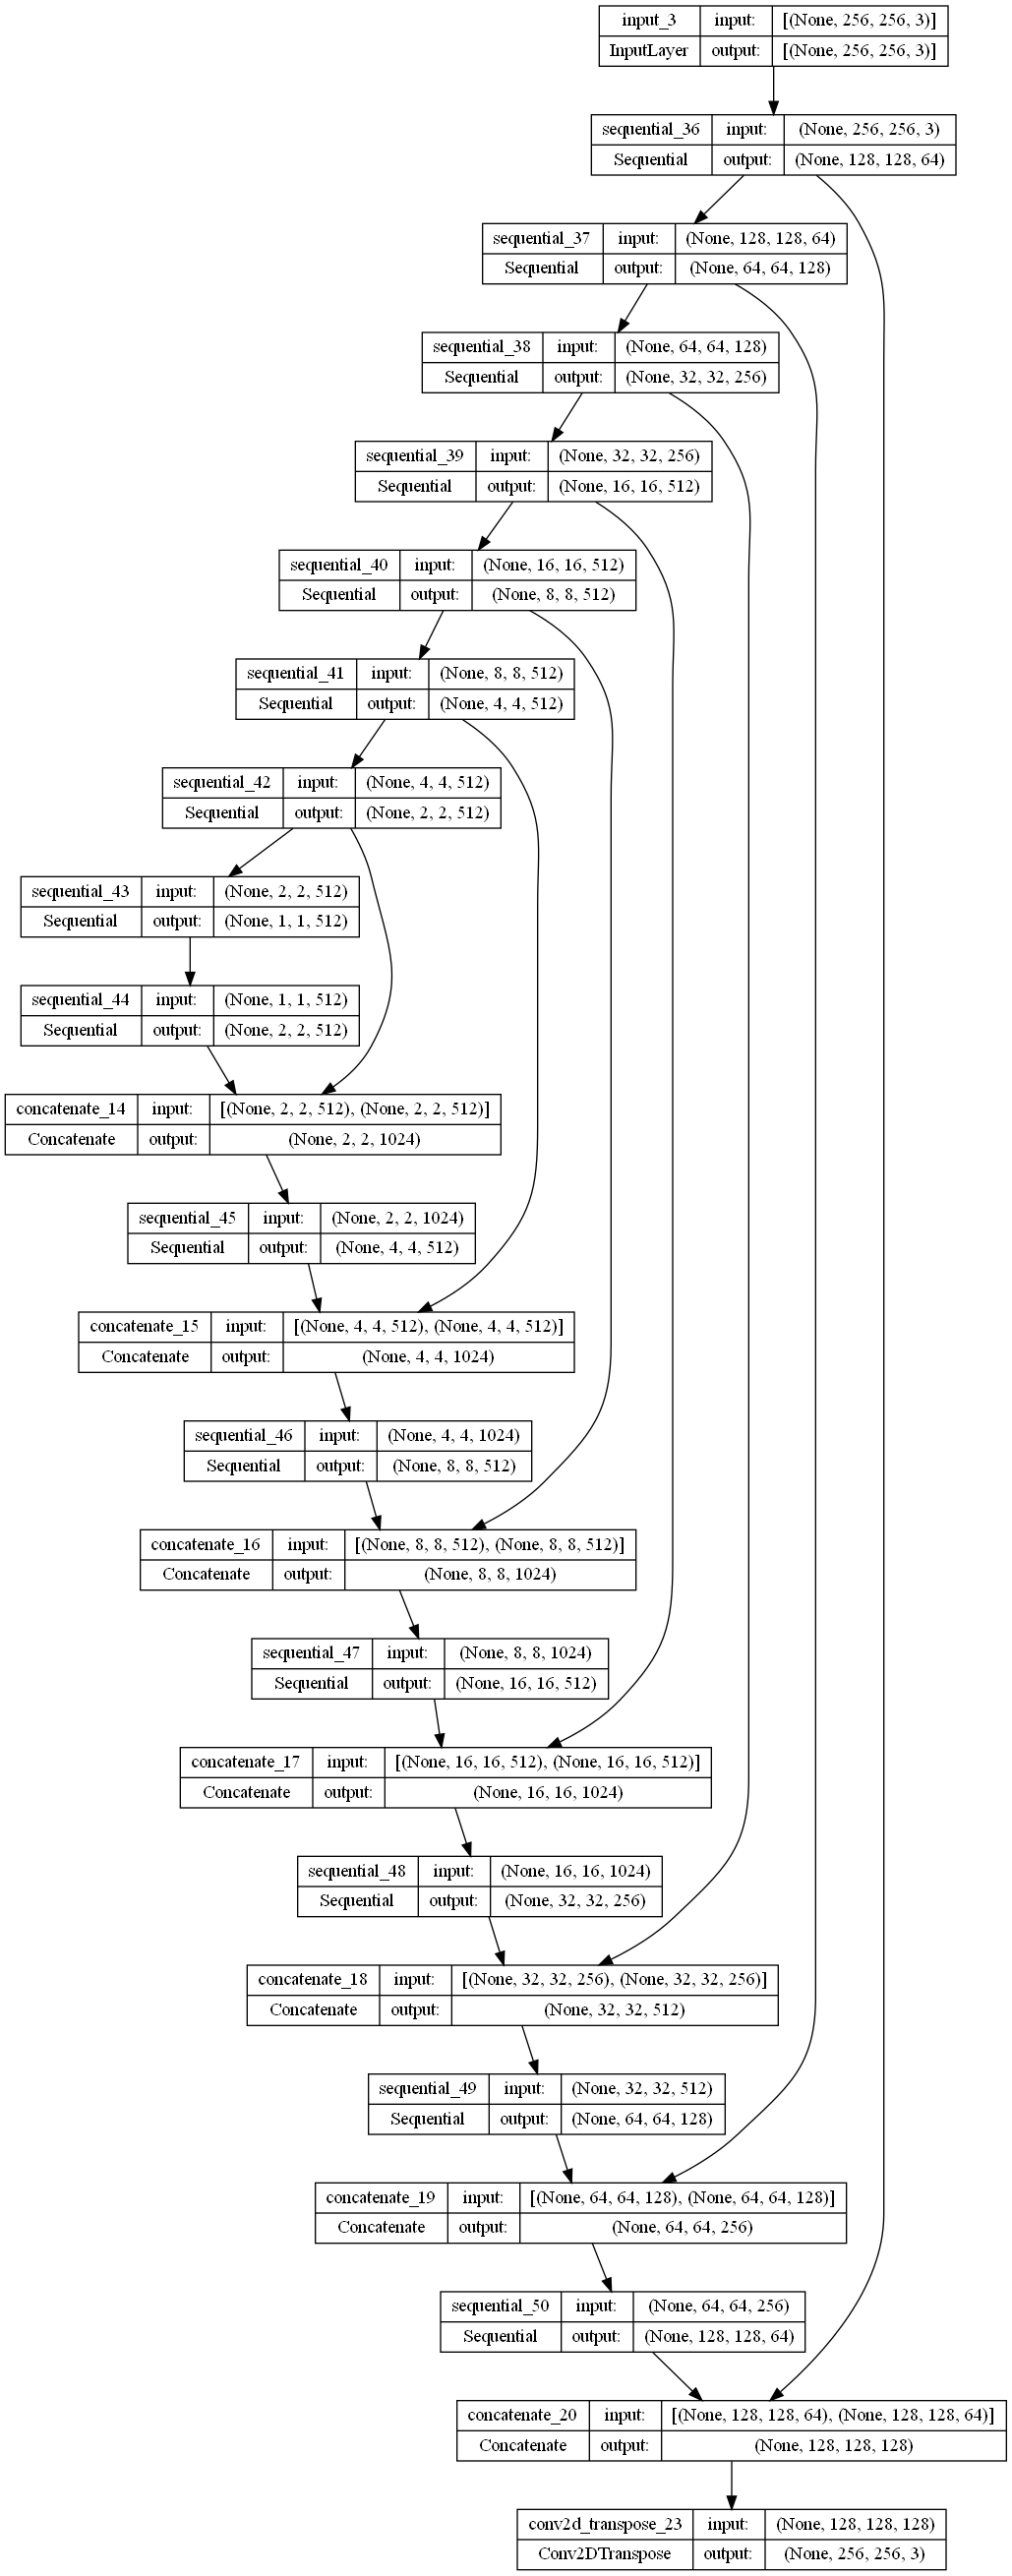

In [26]:
%run -i define_cycle_gan_models.py
plot_model(monet_generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
## Here is a model summary for the generator:
monet_generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_36 (Sequential)     (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_37 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_36[0][0]']          
                                                                                            

## Discriminator Model Overview

The descriminator model starts with 3 downsampling layers which reduce the image dimensions from 256 by 256 down to 32 by 32 in three Conv2D opeations, while the number on convolutional filters has increased to 256 as this stage. Two more Conv2D operations with strides of 1 first increase the number of filters up to 512 and then down to 1. With some zero padding this brings the output size for the descriminator down to a 30 by 30 pixel image with one channel. The descriminator will be trained so that all of the output pixels tend toward higher pixel values for a real classification and lower pixel values for a fake classification.

The discriminator model diagram using keras.utils.vis_utils.plot_model is shown below:

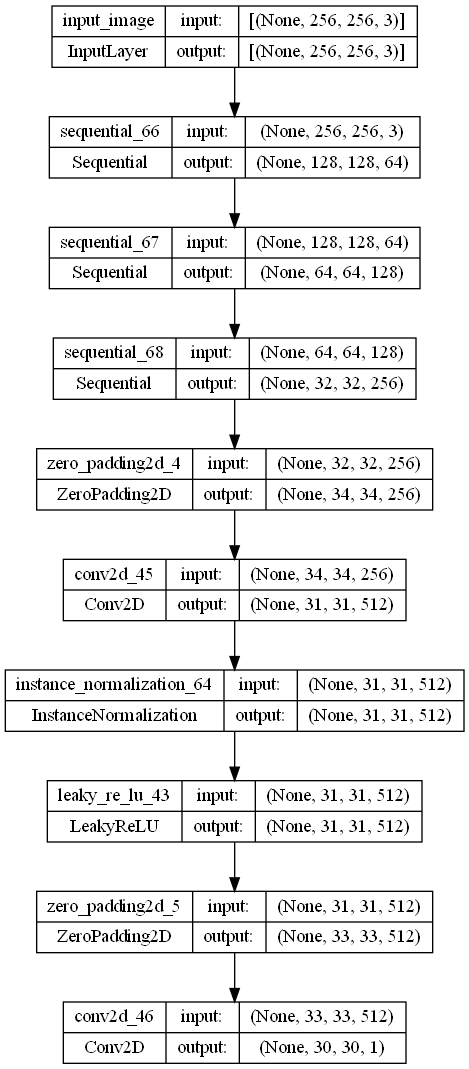

In [28]:
plot_model(monet_discriminator, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
## Here is a model summary for the dicriminator
monet_discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_66 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_67 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_68 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 34, 34, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

## CycleGan Model Overview

The tutorial notebook defines two generators and two descriminators:

* monet_generator -- transforms real photos into Monet-like images
* photo_generator -- trnasforms real Monet images into photo-like images
* monet_discriminator -- binary classification of real Monet images versus generated Monet images
* photo_discriminator -- binary classificaiton of real photos versus generated photo images

Then the class CycleGAN which extends keras.Model defines a train_step method which processes a batch of
Monet images paired with real photos.

For each batch of images the following steps are performed:

1. Real photos are passed through monet_generator to create fake_monet images, which are then passed though photo_generator to produce cycled_photo images. Both generators will be trained to minimimize differences caused by this cycle.

1. Real Monet images are passed through photo_generator to create fake_photo images, which are then passed through monet_generator to produce cycled_monet images. Both generators will be trained to minimize differences caused by this cycle.

1. Real Monet images are passed through monet_generator to create same_monet images. This generator will be trained to minimize differences in this step.

1. Real photos are passed through photo_generatore to create same_photo images. This generator will be trained to minimize differences in this step.

1. Both discriminators are used to classify the batches of  real and generated images of Monet paintings or photos as appropriate.

1. The loss functions for all 4 networks are calculated for the current batch of images.

1. The gradients of the losses  are calculated for all 4 networks with respect to all the trainable variables for each network.

1. The optimizer for each network is used to apply the gradients to its respective trainable variables.

## Loss functions used to train each network

The loss functions are used to train the different networks together in a way that drives the generators toward producing the target style of images while perserving much of the original image content.

The two discriminators are each trained toward producing 1.0 pixel values in a 30 by 30 image for real images and producing 0.0 pixel values for a generated image. Therefore the discriminator loss is calculated a BinaryCrossentropy between the 30 by 30 image and a matrix of all ones for the real images in a batch plus a similar calculation against a matrix of all zeros for the generated images in a batch.

The two generators are trained with a loss consisting of 3 components:

1. Generator_Loss -- Basically the reverse of the corresponding discriminator loss for the generated images. This loss is calculated as the BinaryCrossentry between the 30 by 30 pixel discriminator output and a matrix of all ones for a generated image.

1. Cycle_Loss -- The cycle loss measures information lost by passing each real image (Photo or Monet) through a round trip passing through both generators. This loss is calculated by taking the absolute difference of each pixel value between the original and cycled image and then taking the mean of these absolute differences, as in the following formula:

loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

3. Identity_Loss -- The goal of the generators includes not changing images which are already in the target style. Therefore identity_loss for the monet_generator is calculated based on the difference between a Monet image and the output of the generator for that same image. Similarly the identity_loss for the photo_generator is based on the diffence between a real photo and the output of the photo_generator for that same image. The calculation is similar to Cycle_Loss:

loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

There are a couple of hyperparameters associated with the Cycle_Loss and Identity_Loss calculations. In the tutorial code the Cycle_Loss shown above is multiplied by a parameter LAMBDA (currently set to 10.0) and the Identity_Loss is multiplied by 0.5 * LAMBDA.